In [15]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"
sys.path.insert(1,'/Users/dennis/Documents/myGit/main/myUtils')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
# Utility functions
def genData(num_data, num_features, num_items, seed=42, Q=100, dim=1, deg=1, noise_width=0.5, epsilon=0.1):
    rnd = np.random.RandomState(seed)
    n = num_data
    p = num_features
    m = num_items
    
    x = rnd.normal(0, 1, (n, m, p))
    B = rnd.binomial(1, 0.5, (m, p))

    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            values = (np.dot(B[j], x[i, j].reshape(p, 1)).T / np.sqrt(p) + 3) ** deg + 1
            values *= 5
            values /= 3.5 ** deg
            epislon = rnd.uniform(1 - noise_width, 1 + noise_width, 1)
            values *= epislon
            values = np.ceil(values)
            c[i, j] = values

    c = c.astype(np.float64)
    
    w = rnd.normal(0, 1, (m, p))
    b = rnd.normal(0, 1, (n, m))
    r = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            r[i, j] = np.dot(w[j], x[i, j]) + b[i, j]

    r = 1 / (1 + np.exp(-r))

    return x, r, c, Q

class optModel:
    """
    This is a class for optimization models.
    """

    def __init__(self, r, c, Q, alpha=0.5):
        self.r = r
        self.c = c
        self.Q = Q
        self.alpha = alpha
        self.num_data = num_data
        self.num_items = num_items
        
    def __repr__(self):
        return 'optModel ' + self.__class__.__name__
        

    def setObj(self, r, c):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(r, self.d)))
        else:
            self.objective = cp.sum(cp.power(cp.multiply(r, self.d), 1 - self.alpha)) / (1 - self.alpha)
        
        self.constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(c, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)

    
    # def solve(self, closed=False):
    #     """
    #     A method to solve the optimization problem for one set of parameters.

    #     Args:
    #         r (np.ndarray): The r parameter for the optimization
    #         c (np.ndarray): The c parameter for the optimization
    #         closed (bool): solving the problem in closed form

    #     Returns:
    #         tuple: optimal solution and optimal value
    #     """
    #     if closed:
    #         return self.solveC()

    #     self.d = cp.Variable(self.num_items)
    #     self.setObj(self.r, self.c)
    #     self.problem.solve(abstol=1e-9, reltol=1e-9, feastol=1e-9)
    #     opt_sol = self.d.value
    #     opt_val = self.problem.value

    #     return opt_sol, opt_val


    def solve(self):
        """
        A method to solve the optimization problem in closed form for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization

        Returns:
            tuple: optimal solution and optimal value
        """
        r = self.r
        c = self.c
        if self.alpha == 1:
            raise ValueError("Work in progress")
        
        S = np.sum(c ** (1 - 1 / self.alpha) * r ** (-1 + 1 / self.alpha))
        opt_sol_c = (c ** (-1 / self.alpha) * r ** (-1 + 1 / self.alpha) * self.Q) / S
        opt_val_c = np.sum((r * opt_sol_c) ** (1 - self.alpha)) / (1 - self.alpha)

        return opt_sol_c, opt_val_c
    
class optDataset(Dataset):
    """
    This class is Torch Dataset class for optimization problems.
    """

    def __init__(self, features, costs, r, Q, alpha=0.5, closed=False):
        """
        A method to create a optDataset from optModel

        Args:
            model (optModel): optimization model
            features (np.ndarray): features
            c (np.ndarray): c of objective function
            r (np.ndarray): r of objective function
            Q (float): budget
            alpha (float): alpha of objective function
            closed (bool): solving the problem in closed form

        """
        self.feats = features
        self.costs = costs
        self.r = r
        self.Q = Q
        self.alpha = alpha
        self.closed = closed

        self.sols, self.objs = self._getSols()

    def _getSols(self):
        """
        A method to get the solutions of the optimization problem
        """
        opt_sols = []
        opt_objs = []
        
        for i in tqdm(range(len(self.costs))):
            sol, obj = self._solve(self.r[i], self.costs[i])
            opt_sols.append(sol)
            opt_objs.append([obj])
        
        return np.array(opt_sols), np.array(opt_objs)

    def  _solve(self, r, c):
        """
        A method to solve the optimization problem to get oan optimal solution with given r and c

        Args:
            r (np.ndarray): r of objective function
            c (np.ndarray): c of objective function

        Returns:
            tuple: optimal solution (np.ndarray), objective value (float)
        """
        self.model = optModel(r, c, self.Q, self.alpha)
        if self.closed:
            return self.model.solveC()
        else:
            return self.model.solve()

    def __len__(self):
        """
        A method to get data size

        Returns:
            int: the number of optimization problems
        """
        return len(self.costs)
    
    def __getitem__(self, index):
        """
        A method to retrieve data

        Args:
            index (int): data index

        Returns:
            tuple: data features (torch.tensor), costs (torch.tensor), optimal solutions (torch.tensor) and objective values (torch.tensor)
        """
        return (
            torch.FloatTensor(self.feats[index]), # x 
            torch.FloatTensor(self.costs[index]), # c
            torch.FloatTensor(self.r[index]), # r 
            torch.FloatTensor(self.sols[index]),# optimal solution
            torch.FloatTensor(self.objs[index]), # objective value
        )
    
class LinearRegressionModel(nn.Module):
    def __init__(self, num_items, num_features):
        super(LinearRegressionModel, self).__init__()
        self.num_items = num_items
        self.num_features = num_features
        self.linears = nn.ModuleList([nn.Linear(num_features, 1) for _ in range(num_items)])

    def forward(self, x):
        outputs = []
        for i in range(self.num_items):
            outputs.append(torch.sigmoid(self.linears[i](x[:, i, :])))
        return torch.cat(outputs, dim=1)
    

def regret(predmodel, optmodel, dataloader):
    """
    A function to evaluate model performance with normalized true regret

    Args:
        predmodel (nn): a regression neural network for cost prediction
        optmodel (optModel): an PyEPO optimization model
        dataloader (DataLoader): Torch dataloader from optDataSet

    Returns:
        float: true regret loss
    """
    # evaluate
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        x, c, r, d, z  = data
        # cuda
        if next(predmodel.parameters()).is_cuda:
            x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()
        # predict
        with torch.no_grad(): # no grad
            rp = predmodel(x).to("cpu").detach().numpy()
        # solve
        for j in range(rp.shape[0]):
            # accumulate loss
            loss += calRegret(optModel, c[j].to("cpu").detach().numpy(), rp[j], r[j].to("cpu").detach().numpy(),
                              z[j].item())
        optsum += abs(z).sum().item()
    # turn back train mode
    predmodel.train()
    # normalized
    return loss / (optsum + 1e-7)

def objValue(d, r, alpha=0.5):
    """
    A function to calculate objective value
    """
    if alpha == 1:
        return np.sum(np.log(np.multiply(r, d)))
    else:
        return np.sum(np.power(np.multiply(r, d), 1 - alpha)) / (1 - alpha)



def calRegret(optmodel, cost, pred_r, true_r, true_obj):
    """
    A function to calculate normalized true regret for a batch

    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_cost (torch.tensor): true costs
        true_obj (torch.tensor): true optimal objective values

    Returns:predmodel
        float: true regret losses
    """
    # opt sol for pred cost
    model = optmodel(pred_r, cost, Q, alpha=0.5)
    sol, _ = model.solve()
    # obj with true cost
    obj = objValue(sol, true_r, alpha=0.5)
    # loss
    loss = true_obj - obj
    return loss

# Define the visualization function
def visLearningCurve(loss_log, loss_log_regret):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

In [17]:
num_data = 200
num_features = 20
num_items = 10

x, r, c, Q = genData(num_data, num_features, num_items)
optmodel = optModel(r, c, Q, alpha=0.5)

In [18]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test, r_train, r_test = train_test_split(x, c, r, test_size=0.2, random_state=42)

# Create datasets and dataloaders
dataset_train = optDataset(x_train, c_train, r_train, Q, alpha=0.5, closed=False)
dataset_test = optDataset(x_test, c_test, r_test, Q, alpha=0.5, closed=False)
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

100%|██████████| 40/40 [00:00<00:00, 39983.83it/s]


In [19]:
from torch.autograd import Function

class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        for i in range(batch_size):
            # opt sol for pred cost
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _ = model.solve()
            # obj with true cost
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.losses = losses
        
        return losses.mean().to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):
        pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        
        epsilon = 1e-5

        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()
            
            gradient = np.zeros_like(pred_r_np)
            
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                perturbed_pred_r[j] += epsilon
                
                # Compute loss with perturbed pred_r
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _ = model.solve()
                obj = objValue(sol, true_r_np, alpha=alpha)
                loss_perturbed = true_obj[i] - obj
                
                # Finite difference approximation
                gradient[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            grad_pred_r[i] = torch.tensor(gradient, device=pred_r.device)
        
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r
        
        return None, None, grad_pred_r, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q, alpha=0.5):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


In [20]:
def trainModel(predmodel, loss_func, num_epochs=10, lr=1e-2):
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    predmodel.train()
    loss_log = []
    loss_log_regret = [regret(predmodel, optmodel, loader_test)]
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        for i, data in enumerate(loader_train):
            x, c, r, d, z = data
            if torch.cuda.is_available():
                x, c, r, d, z = x.cuda(), c.cuda(), r.cuda(), d.cuda(), z.cuda()

            optimizer.zero_grad()
            rp = predmodel(x)
            # loss = loss_func(rp, r) if using torch.nn.MSELoss
            loss = criterion(rp, r, c, z)

            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())

        regret_loss = regret(predmodel, optmodel, loader_test)
        loss_log_regret.append(regret_loss)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch + 1, loss.item(), regret_loss * 100))

    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

Epoch  1,  Loss:    2.5280,  Regret: 13.3408%
Epoch  2,  Loss:    2.1698,  Regret: 12.1330%
Epoch  3,  Loss:    1.9886,  Regret: 11.0428%
Epoch  4,  Loss:    1.8182,  Regret: 10.0624%
Epoch  5,  Loss:    1.8339,  Regret:  9.1827%
Epoch  6,  Loss:    1.5082,  Regret:  8.3863%
Epoch  7,  Loss:    1.2237,  Regret:  7.6682%
Epoch  8,  Loss:    1.2483,  Regret:  7.0288%
Epoch  9,  Loss:    1.1283,  Regret:  6.4677%
Epoch 10,  Loss:    0.9366,  Regret:  5.9578%
Total Elapsed Time: 8.14 Sec.


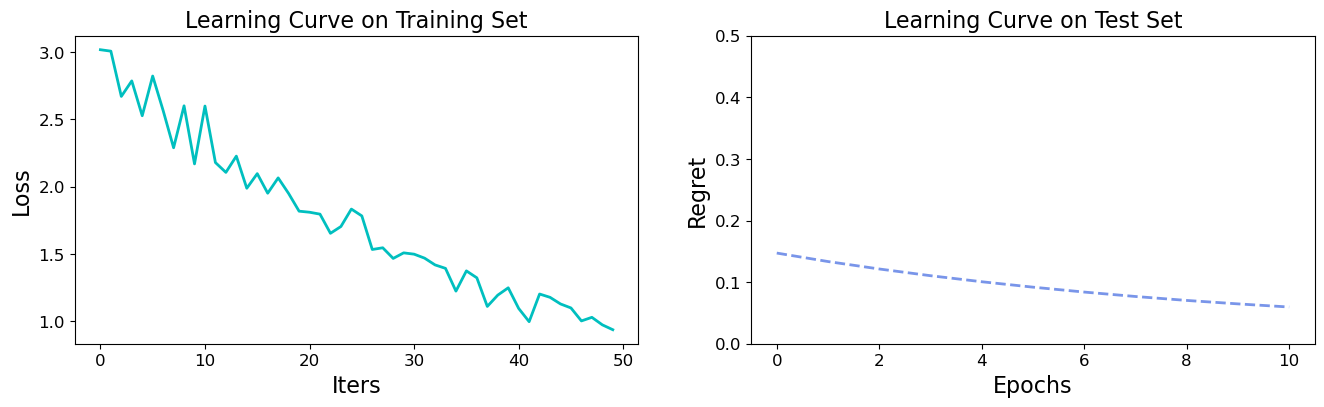

In [21]:
# Set up the model, optimizer, and MSE loss
optmodel = optModel
model = LinearRegressionModel(num_items, num_features).to(device)
# criterion = nn.MSELoss()
criterion = RegretLoss(optModel, Q)

# Run the training
loss_log, loss_log_regret = trainModel(model, criterion, num_epochs=10, lr=1e-2)

# Visualize the learning curves
visLearningCurve(loss_log, loss_log_regret)